In [5]:
import numpy as np
import pandas as pd

# For reproducibility
np.random.seed(42)

In [6]:

# Define number of samples
num_samples = 10000


# Generate base features for normal operation
base_temp = np.random.normal(loc=50, scale=5, size=num_samples)
base_press = np.random.normal(loc=1500, scale=100, size=num_samples)

base_mmcfd = np.random.normal(loc=10, scale=2, size=num_samples)
base_bopd = np.random.normal(loc=500, scale=50, size=num_samples)
base_bwpd = np.random.normal(loc=200, scale=30, size=num_samples)
base_bsw = np.random.normal(loc=5, scale=1, size=num_samples)
base_co2 = np.random.normal(loc=1, scale=0.1, size=num_samples)
base_gas_grav = np.random.normal(loc=0.65, scale=0.05, size=num_samples)
base_cr = np.random.normal(loc=0.1, scale=0.02, size=num_samples)

# Initialize arrays for the features
temperature = np.zeros(num_samples)
pressure = np.zeros(num_samples)
mmcfd = np.zeros(num_samples)
bopd = np.zeros(num_samples)
bwpd = np.zeros(num_samples)
bsw = np.zeros(num_samples)
co2 = np.zeros(num_samples)
gas_grav = np.zeros(num_samples)
cr = np.zeros(num_samples)
labels = np.zeros(num_samples)

# Define leak severity levels
leak_levels = [0, 1, 2, 3]  # 0: No leak, 1: Minor leak, 2: Moderate leak, 3: Severe leak
proportions = [0.5, 0.2, 0.2, 0.1]  # Proportion of each severity level

# Generate data for each severity level
start_idx = 0
for level, proportion in zip(leak_levels, proportions):
    end_idx = start_idx + int(proportion * num_samples)
    if level == 0:
        # Normal operation
        temperature[start_idx:end_idx] = base_temp[start_idx:end_idx]
        pressure[start_idx:end_idx] = base_press[start_idx:end_idx]
        mmcfd[start_idx:end_idx] = base_mmcfd[start_idx:end_idx]
        bopd[start_idx:end_idx] = base_bopd[start_idx:end_idx]
        bwpd[start_idx:end_idx] = base_bwpd[start_idx:end_idx]
        bsw[start_idx:end_idx] = base_bsw[start_idx:end_idx]
        co2[start_idx:end_idx] = base_co2[start_idx:end_idx]
        gas_grav[start_idx:end_idx] = base_gas_grav[start_idx:end_idx]
        cr[start_idx:end_idx] = base_cr[start_idx:end_idx]
        labels[start_idx:end_idx] = 0
    else:
        # Leak conditions
        severity_factor = level * 0.2  # Increasing factor based on severity
        temperature[start_idx:end_idx] = base_temp[start_idx:end_idx] + severity_factor * np.random.normal(loc=5, scale=1, size=end_idx-start_idx)
        pressure[start_idx:end_idx] = base_press[start_idx:end_idx] - severity_factor * np.random.normal(loc=300, scale=50, size=end_idx-start_idx)
        mmcfd[start_idx:end_idx] = base_mmcfd[start_idx:end_idx] - severity_factor * np.random.normal(loc=3, scale=0.5, size=end_idx-start_idx)
        bopd[start_idx:end_idx] = base_bopd[start_idx:end_idx] - severity_factor * np.random.normal(loc=200, scale=30, size=end_idx-start_idx)
        bwpd[start_idx:end_idx] = base_bwpd[start_idx:end_idx] + severity_factor * np.random.normal(loc=100, scale=20, size=end_idx-start_idx)
        bsw[start_idx:end_idx] = base_bsw[start_idx:end_idx] + severity_factor * np.random.normal(loc=3, scale=0.5, size=end_idx-start_idx)
        co2[start_idx:end_idx] = base_co2[start_idx:end_idx] + severity_factor * np.random.normal(loc=0.5, scale=0.1, size=end_idx-start_idx)
        gas_grav[start_idx:end_idx] = base_gas_grav[start_idx:end_idx] + severity_factor * np.random.normal(loc=0.1, scale=0.02, size=end_idx-start_idx)
        cr[start_idx:end_idx] = base_cr[start_idx:end_idx] + severity_factor * np.random.normal(loc=0.2, scale=0.05, size=end_idx-start_idx)
        labels[start_idx:end_idx] = level
    start_idx = end_idx

# Create a DataFrame
data = pd.DataFrame({
    'Wellhead_Temp. (C)': temperature,
    'Wellhead_Press (psi)': pressure,
    'MMCFD- gas': mmcfd,
    'BOPD (barrel of oil produced per day)': bopd,
    'BWPD (barrel of water produced per day)': bwpd,
    'BSW basic solid and water(%)': bsw,
    'CO2 mol. (%) @ 25C & 1 Atm': co2,
    'Gas Grav': gas_grav,
    'CR-corrosion defect': cr,
    'leak_status': labels
})

# Shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)

# Display the first few rows
data.head()

,Wellhead_Temp. (C),Wellhead_Press (psi),MMCFD- gas,BOPD (barrel of oil produced per day),BWPD (barrel of water produced per day),BSW basic solid and water(%),CO2 mol. (%) @ 25C & 1 Atm,Gas Grav,CR-corrosion defect,leak_status
0,51.088486,1364.601753,6.784434,404.673699,293.125995,5.265676,1.038911,0.601146,0.144365,1.0
1,51.096512,1474.635955,11.280674,364.764774,208.472370,5.331766,0.961022,0.618705,0.135026,0.0
2,57.631303,1233.116598,8.786931,414.652564,228.530184,5.696270,1.295514,0.712029,0.154846,1.0
3,55.413455,1564.958133,10.793411,511.357422,161.711604,6.073352,0.801719,0.640946,0.108198,0.0
4,36.821261,1500.806676,12.748623,537.593023,185.303039,4.867634,1.049567,0.644026,0.114479,0.0


In [7]:
# Save the dataset to a CSV file

data.to_csv('data.csv', index=False)
print('done')

done


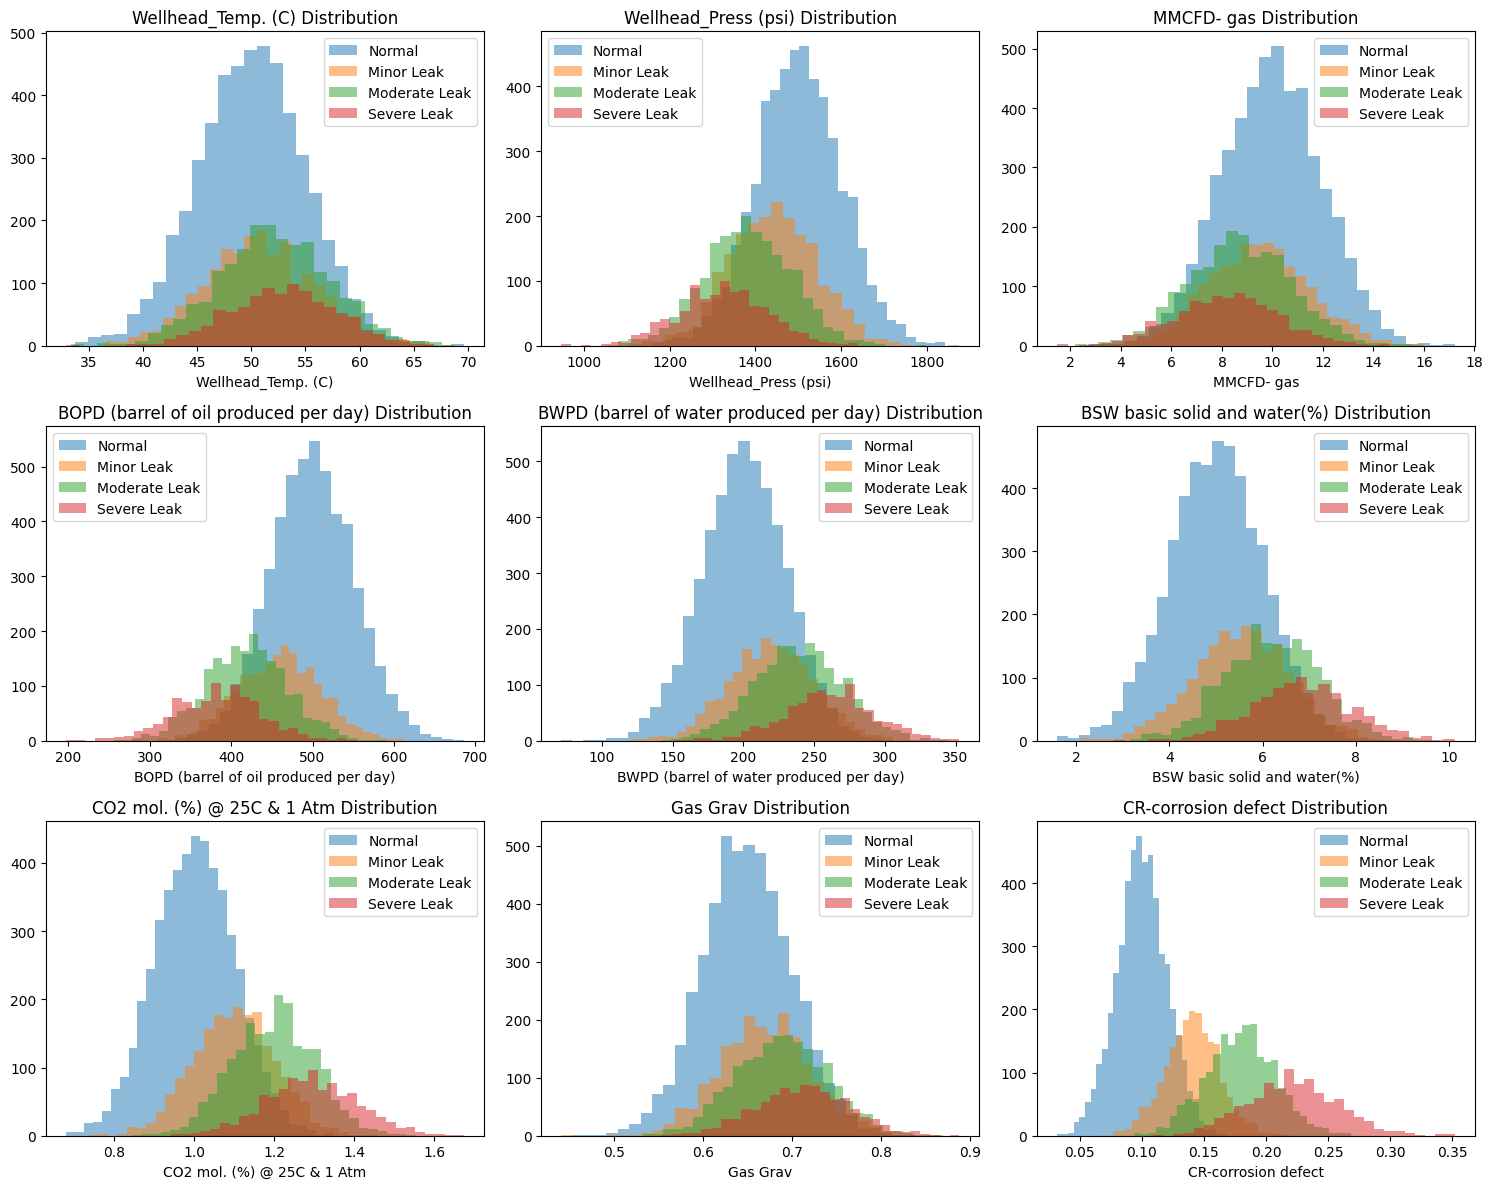

In [8]:
import matplotlib.pyplot as plt
data = data.sample(frac=1).reset_index(drop=True)

# Plot to visualize the generated data
plt.figure(figsize=(15, 12))

# Define labels for the severity levels
severity_labels = ['Normal', 'Minor Leak', 'Moderate Leak', 'Severe Leak']

# Plot histograms for each feature
features = ['Wellhead_Temp. (C)', 'Wellhead_Press (psi)', 'MMCFD- gas', 'BOPD (barrel of oil produced per day)', 'BWPD (barrel of water produced per day)', 'BSW basic solid and water(%)', 'CO2 mol. (%) @ 25C & 1 Atm', 'Gas Grav', 'CR-corrosion defect']

for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    for level in range(4):
        plt.hist(data[data['leak_status'] == level][feature], bins=30, alpha=0.5, label=severity_labels[level])
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.legend()

plt.tight_layout()
plt.show()